In [1]:
import numpy as np
import numpy.linalg as la

import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

import modern_robotics as mr

import networkx as nx

from description.kinematics import JointPoint

In [58]:
graph = nx.Graph()
# https://cad.onshape.com/documents/52eb11422c701d811548a6f5/w/655758bb668dff773a0e7c1a/e/77ff7f84e82d8fb31fe9c30b
# abs_ground = np.array([0.065, 0, -0.015])
abs_ground = np.array([0.065, 0, -0.047])
pos_toeA_joint = np.array([0.065, 0, -0.047]) - abs_ground
pos_toeA_tarus_joint = np.array([-0.273, 0, -0.350]) - abs_ground
pos_shin_joint = np.array([0.021, 0, -0.159]) - abs_ground
pos_knee_spring = np.array([0.011, 0, -0.219]) - abs_ground
pos_tarus_joint = np.array([-0.237, 0, -0.464]) - abs_ground
pos_foot_joint = np.array([-0.080, 0, -0.753]) - abs_ground
pos_molet_joint = np.array([-0.207, 0, -0.552]) - abs_ground
pos_toeB_joint = np.array([-0.257, 0, -0.579]) - abs_ground
pos_toeB_foot_joint = np.array([-0.118, 0, -0.776]) - abs_ground

ground_joint = JointPoint(r=np.zeros(3), w=np.array([0,1,0]), attach_ground=True, active=True)
shin_joint = JointPoint(r=pos_shin_joint, w=np.array([0,1,0]), active=True)
knee_spring = JointPoint(pos_knee_spring, w=np.array([0,1,0]), weld=True)
tarus_joint = JointPoint(r=pos_tarus_joint, w=np.array([0,1,0]))
foot_joint = JointPoint(r=pos_foot_joint, w=np.array([0,1,0]), attach_endeffector=True)

toeA_joint = JointPoint(r=pos_toeA_joint, w=np.array([0,1,0]))
connect_toeA_tarus_joint = JointPoint(r=pos_toeA_tarus_joint, w=np.array([0,1,0]), weld=True)

molet_joint = JointPoint(r=pos_molet_joint, w=np.array([0,1,0]), active=True)
toeB_joint = JointPoint(r=pos_toeB_joint, w=np.array([0,1,0]))
toeB_foot_joint = JointPoint(r=pos_toeB_foot_joint, w=np.array([0,1,0]), attach_endeffector=True)

joints = [ground_joint, shin_joint, knee_spring, tarus_joint, foot_joint, toeA_joint, connect_toeA_tarus_joint,
            molet_joint, toeB_joint, toeB_foot_joint]

for j in joints:
    graph.add_node(j)
main_branch = [ground_joint, shin_joint, knee_spring, tarus_joint, foot_joint]
add_branch_1 = [[ground_joint,shin_joint], toeA_joint, connect_toeA_tarus_joint, [tarus_joint,foot_joint]]
add_branch_2 = [[tarus_joint,foot_joint], molet_joint, toeB_joint, toeB_foot_joint, foot_joint]

In [59]:
def calc_weight(n0, n1):
    norm = la.norm(n0.r-n1.r)
    norm = norm if not np.isclose(norm, 0) else 1e5
    return 1/(norm)

In [60]:
for id in range(len(main_branch)-1):
    graph.add_edge(main_branch[id],main_branch[id+1], variable = False, active = False, weight = calc_weight(main_branch[id],main_branch[id+1]))
for id in range(len(add_branch_1)-1):
    if isinstance(add_branch_1[id], list):
        for j in add_branch_1[id]:
            graph.add_edge(j,add_branch_1[id+1], variable = False, active = False, weight = calc_weight(j,add_branch_1[id+1]))
    elif isinstance(add_branch_1[id+1], list):
        for j in add_branch_1[id+1]:
            graph.add_edge(j,add_branch_1[id], variable = False, active = False, weight = calc_weight(j,add_branch_1[id]))
    else:
            graph.add_edge(add_branch_1[id],add_branch_1[id+1], variable = False, active = False, weight = calc_weight(add_branch_1[id],add_branch_1[id+1]))
for id in range(len(add_branch_2)-1):
    if isinstance(add_branch_2[id], list):
        for j in add_branch_2[id]:
            graph.add_edge(j,add_branch_2[id+1], variable = False, active = False, weight = calc_weight(j,main_branch[id+1]))
    elif isinstance(add_branch_2[id+1], list):
        for j in add_branch_2[id+1]:
            graph.add_edge(j,add_branch_2[id], variable = False, active = False, weight = calc_weight(j,add_branch_2[id]))
    else:
            graph.add_edge(add_branch_2[id],add_branch_2[id+1], variable = False, active = False, weight = calc_weight(add_branch_2[id],add_branch_2[id+1]))

In [61]:
pos = {}
for node in graph:
    pos[node] = [node.r[0],node.r[2]]

In [143]:
R = 0.751618254168963
joint_nodes = set(graph.nodes())
ground_joints = set(sorted(filter(lambda n: n.attach_ground, joint_nodes), key= lambda x: la.norm(x.r)))
ee_joints = set(sorted(filter(lambda n: n.attach_endeffector, joint_nodes), key= lambda x: np.abs(la.norm(x.r) - R)))
ground_joints, ee_joints

({JointPoint(r=array([0., 0., 0.]), w=array([0, 1, 0]), weld=False, active=True, attach_ground=True, attach_endeffector=False, instance_counter=0)},
 {JointPoint(r=array([-0.145,  0.   , -0.706]), w=array([0, 1, 0]), weld=False, active=False, attach_ground=False, attach_endeffector=True, instance_counter=0),
  JointPoint(r=array([-0.183,  0.   , -0.729]), w=array([0, 1, 0]), weld=False, active=False, attach_ground=False, attach_endeffector=True, instance_counter=0)})

In [34]:
shin_joint

JointPoint(r=array([-0.044,  0.   , -0.112]), w=array([0, 1, 0]), weld=False, active=True, attach_ground=False, attach_endeffector=False, instance_counter=0)

делать это рекурсивно

In [51]:
len(graph.nodes())

10

In [171]:
from dataclasses import dataclass, field


@dataclass
class Link:
    name: str = ""
    joints: set[JointPoint] = field(default_factory=set)
    instance_counter: int = 0

    def __post_init__(self):
        Link.instance_counter += 1
        self.instance_counter = Link.instance_counter
        if self.name == "":
            self.name = "L" + str(self.instance_counter)

    def __hash__(self) -> int:
        return hash((self.name, *self.joints))
    
    def __eq__(self, __value: object) -> bool:
        self.joints == __value.joints

In [109]:
from collections import deque

stack_joints = deque(maxlen=len(graph.nodes()))

ground_link = {"joints":ground_joints, "main":ground_joints[0]}
ee_link = {"joints":ee_joints, "main":ee_joints[0]}

stack_joints += ground_link["joints"]
j_has_link = set(ground_link["joints"]).union(ee_link["joints"])
explored_joints = set()
Links = [ground_link, ee_link]
while stack_joints:
    curr_j = stack_joints.pop()
    explored_joints.add(curr_j)
    neighbor = set(graph.neighbors(curr_j))
    if neighbor.issubset(j_has_link):
        if len(neighbor) > 1:
            more1neighbor_onelink = filter(lambda link: len(neighbor.intersection(set(link["joints"]))) > 1, Links)
            for link in more1neighbor_onelink:
                link["joints"].append(curr_j)
        else:
            continue
    Links.append({"joints":[curr_j]})
    if len(neighbor - j_has_link) > 1:
        joint_links = set()
        for n in neighbor:
            joint_links = joint_links.union(neighbor.intersection(set(graph.neighbors(n))))
        Links[-1]["joints"] += list(joint_links)
        stack_joints += list(joint_links - explored_joints)
        j_has_link.update(joint_links)
    else:
        try:
            Links[-1]["joints"].append((neighbor - (j_has_link - set(ee_link["joints"]))).pop())
            if neighbor not in explored_joints:
                stack_joints.append((neighbor- j_has_link).pop())
            j_has_link.add((neighbor - (j_has_link)).pop())
        except KeyError:
            continue

In [152]:
from collections import deque

stack_joints = deque(maxlen=len(graph.nodes()))

ground_link = Link("ground", ground_joints)
ee_link = Link("EndEffector", ee_joints)

j_has_link = {j:0 for j in graph.nodes()}
j2link = {j:[ground_link] for j in ground_joints}
for j in ground_joints:
    j2link[j] = [ground_link]
    j_has_link[j] += 1
for ee_j in ee_joints:
    if ee_j in j2link:
        j2link[ee_j].append(ee_link)
    else:
        j2link[ee_j] = [ee_link]
    j_has_link[ee_j] += 1

stack_joints += list(ground_link.joints)
explored_j = set()
links = [ee_link, ground_link]
while stack_joints:
    curr_j = stack_joints.pop()
    explored_j.add(curr_j)
    neighbor = set(graph.neighbors(curr_j))
    
    if len(neighbor & set(j_has_link.keys())) > 1:
        more1neighbor_onelink = filter(lambda link: len(neighbor.intersection(link.joints)) > 1, links)
        for link in more1neighbor_onelink:
            link.joints.add(curr_j)
        j_has_link[curr_j] +=1
    close_j = set(dict(filter(lambda x: x[1] == 2, j_has_link.items())).keys())
    hanging_j = set(dict(filter(lambda x: x[1] == 1, j_has_link.items())).keys())

    neighbor -= close_j - links[-1].joints
    if neighbor > 1:
        joint_links = set()
        for n in neighbor:
            joint_links = joint_links.union(neighbor.intersection(set(graph.neighbors(n))))
        joint_links = set([curr_j]).union(neighbor)
    else:
        neighbor = neighbor.pop()
        links.append(Link(joints=joint_links))
        joint_links = set([curr_j, neighbor])
        stack_joints.append(neighbor)
    for j in joint_links:
        j_has_link[j] += 1

TypeError: '>' not supported between instances of 'set' and 'int'

In [186]:
from inspect import stack


stack_joints = deque(maxlen=len(graph.nodes()))

ground_link = Link("ground", ground_joints)
ee_link = Link("EndEffector", ee_joints)

j_has_link = {j:0 for j in graph.nodes()}
j2link = {j:[ground_link] for j in ground_joints}
for j in ground_joints:
    j2link[j] = [ground_link]
    j_has_link[j] += 1
for ee_j in ee_joints:
    if ee_j in j2link:
        j2link[ee_j].append(ee_link)
    else:
        j2link[ee_j] = [ee_link]
    j_has_link[ee_j] += 1

stack_joints += list(ground_link.joints)
explored_j = set()
links = [ee_link, ground_link]
while stack_joints:
    curr_j = stack_joints.pop()
    explored_j.add(curr_j)
    neighbor = set(graph.neighbors(curr_j))
    
    if len(neighbor & explored_j) > 1:
        more1neighbor_onelink = filter(lambda link: len(neighbor.intersection(link.joints)) > 1, links)
        for link in more1neighbor_onelink:
            link.joints.add(curr_j)
        j_has_link[curr_j] +=1
    close_j = set(dict(filter(lambda x: x[1] > 1, j_has_link.items())).keys())
    hanging_j = set(dict(filter(lambda x: x[1] == 1, j_has_link.items())).keys())

    neighbor = neighbor -  close_j - links[-1].joints
    view_joints = neighbor | set([curr_j])
    if len(view_joints) > 2:
        for n in neighbor:
            view_joints = view_joints.union(neighbor.intersection(set(graph.neighbors(n))))
    links.append(Link(joints=view_joints))
    stack_joints += list(neighbor - explored_j)
    for j in view_joints:
        j_has_link[j] += 1
    close_j = set(dict(filter(lambda x: x[1] > 1, j_has_link.items())).keys())
    for j in close_j:
        if j in stack_joints:
            stack_joints.remove(j)

In [187]:
links

[Link(name='EndEffector', joints={JointPoint(r=array([-0.183,  0.   , -0.729]), w=array([0, 1, 0]), weld=False, active=False, attach_ground=False, attach_endeffector=True, instance_counter=0), JointPoint(r=array([-0.145,  0.   , -0.706]), w=array([0, 1, 0]), weld=False, active=False, attach_ground=False, attach_endeffector=True, instance_counter=0)}, instance_counter=15),
 Link(name='ground', joints={JointPoint(r=array([0., 0., 0.]), w=array([0, 1, 0]), weld=False, active=True, attach_ground=True, attach_endeffector=False, instance_counter=0)}, instance_counter=14),
 Link(name='L16', joints={JointPoint(r=array([0., 0., 0.]), w=array([0, 1, 0]), weld=False, active=True, attach_ground=True, attach_endeffector=False, instance_counter=0), JointPoint(r=array([-0.044,  0.   , -0.112]), w=array([0, 1, 0]), weld=False, active=True, attach_ground=False, attach_endeffector=False, instance_counter=0), JointPoint(r=array([0., 0., 0.]), w=array([0, 1, 0]), weld=False, active=False, attach_ground=Fa

[[-0.302 -0.417]
 [-0.054 -0.172]
 [-0.272 -0.505]]


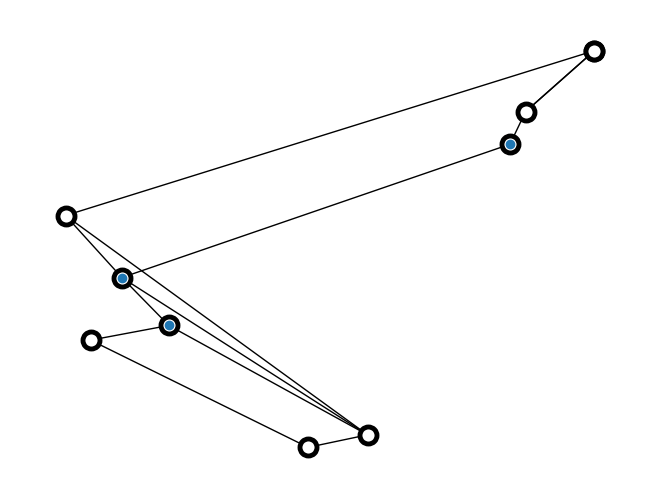

In [188]:
nx.draw(graph, pos, node_color="w", linewidths=3.5, edgecolors="k", node_shape="o",node_size=150, with_labels=False)
points =[]
LL = [links[5]]
for link in LL:
    pp = []
    for j in link.joints:
        pp.append([j.r[0],j.r[2]])
    pp = np.array(pp)
    print(pp)
    plt.plot(pp[:,0], pp[:,1], "o")

In [75]:
pp[:,0]

array([0.])

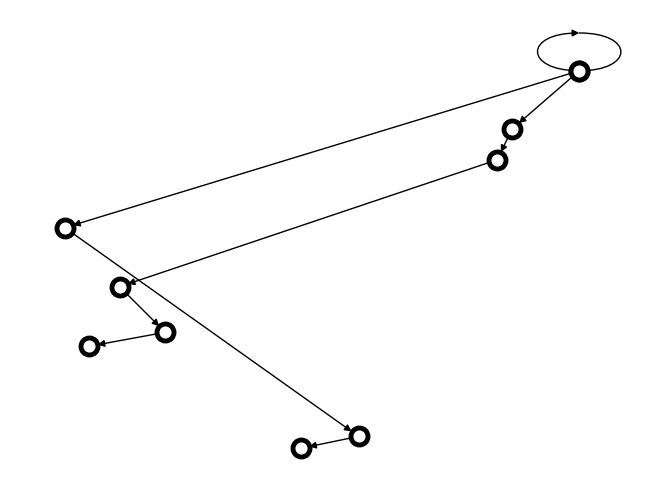

In [16]:
nx.draw(nx.bfs_tree(graph, ground_joints[0]), pos, node_color="w", linewidths=3.5, edgecolors="k", node_shape="o",node_size=150, with_labels=False)

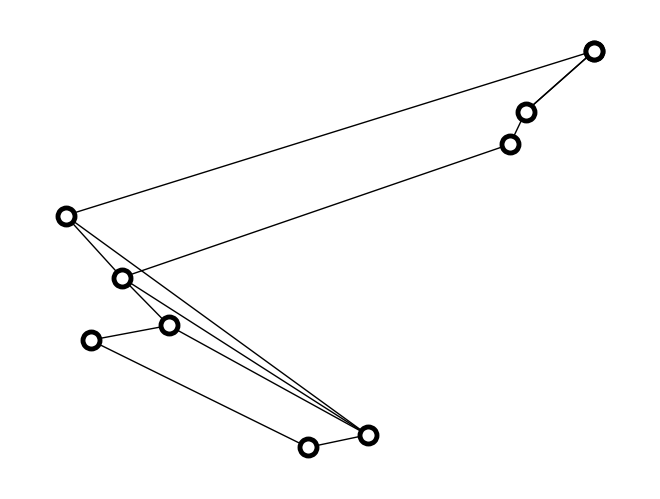

In [6]:
nx.draw(graph, pos, node_color="w", linewidths=3.5, edgecolors="k", node_shape="o",node_size=150, with_labels=False)

In [8]:
def get_rot_matrix_by_vec(v):
    ez = np.array([0,0,1])
    ex = np.array([1,0,0])
    # axis = np.sign(np.inner(ex, v)) * mr.VecToso3(ez) @ v/ np.linalg.norm(mr.VecToso3(ez) @ v)
    axis = mr.VecToso3(ez) @ v/ np.linalg.norm(mr.VecToso3(ez) @ v)
    angle = np.arccos(np.inner(ez, v) / la.norm(ez) / la.norm(v))
    out = lambda q: R.from_rotvec(axis * (angle + np.sign(np.inner(ex, v)) * q), )
    print(axis, mr.VecToso3(ez) @ v/ np.linalg.norm(mr.VecToso3(ez) @ v), angle)
    return out 

In [10]:
ez = np.array([0,0,1])
ex = np.array([1,0,0])

v1z = main_branch[1].r - main_branch[0].r

In [11]:
R1 = get_rot_matrix_by_vec(v1z)

H_w_b1 = np.eye(4)
H_w_b1[:3,:3] = R1(0).as_matrix()

[ 0. -1.  0.] [ 0. -1.  0.] 2.767259037582209


In [13]:
v2z = main_branch[2].r - main_branch[1].r

v2z_l = la.inv(H_w_b1) @ np.array([*v2z.tolist(), 1])

R2 = get_rot_matrix_by_vec(v2z_l[:3])

H_b1_b2 = np.eye(4)
H_b1_b2[:3,:3] = R2(0).as_matrix()
H_b1_b2[:3,3] = np.array([0,0,la.norm(v1z)])

[ 0. -1.  0.] [ 0. -1.  0.] 0.20918493859295728


In [14]:
v3z = main_branch[3].r - main_branch[2].r

# v3z_l = R2(0).as_matrix().T @ R1(0).as_matrix().T @ v3z
v3z_l = la.inv(H_b1_b2) @ la.inv(H_w_b1) @ np.array([*v3z.tolist(), 0])


R3 = get_rot_matrix_by_vec(v3z_l[:3])

H_b2_b3 = np.eye(4)
H_b2_b3[:3,:3] = R3(0).as_matrix()
# H_b2_b3[:3,3] = v2z_l
H_b2_b3[:3,3] = np.array([0,0,la.norm(v2z)])

[0. 1. 0.] [0. 1. 0.] 0.6263346035715688


In [15]:
v3z_l, v3z, la.inv(H_b2_b3) @ v2z_l

(array([0.20434794, 0.        , 0.28243746, 0.        ]),
 array([-0.248,  0.   , -0.245]),
 array([-0.00945663,  0.        , -0.00847871,  1.        ]))

In [16]:
q1 = 0
q2 = 0
q3 = 0

H_w_b1 = np.eye(4)
H_w_b1[:3,:3] = R1(q1).as_matrix()
# H_w_b1[:3,3] = np.array([0,0,la.norm(v1z)])

H_b1_b2 = np.eye(4)
H_b1_b2[:3,:3] = R2(q2).as_matrix()
H_b1_b2[:3,3] = np.array([0,0,la.norm(v1z)])
# H_b1_b2[:3,3] = np.array([0,0,la.norm(v2z)])
# H_b1_b2[:3,3] = v1z

H_b2_b3 = np.eye(4)
H_b2_b3[:3,:3] = R3(q3).as_matrix()
# H_b2_b3[:3,3] = v2z_l
H_b2_b3[:3,3] = np.array([0,0,la.norm(v2z)])
# H_b2_b3[:3,3] = np.array([0,0,0])

не сходится вращение и однородное преобразование

(-0.37349000000000004, 0.03549000000000001, -0.805545, 0.076545)

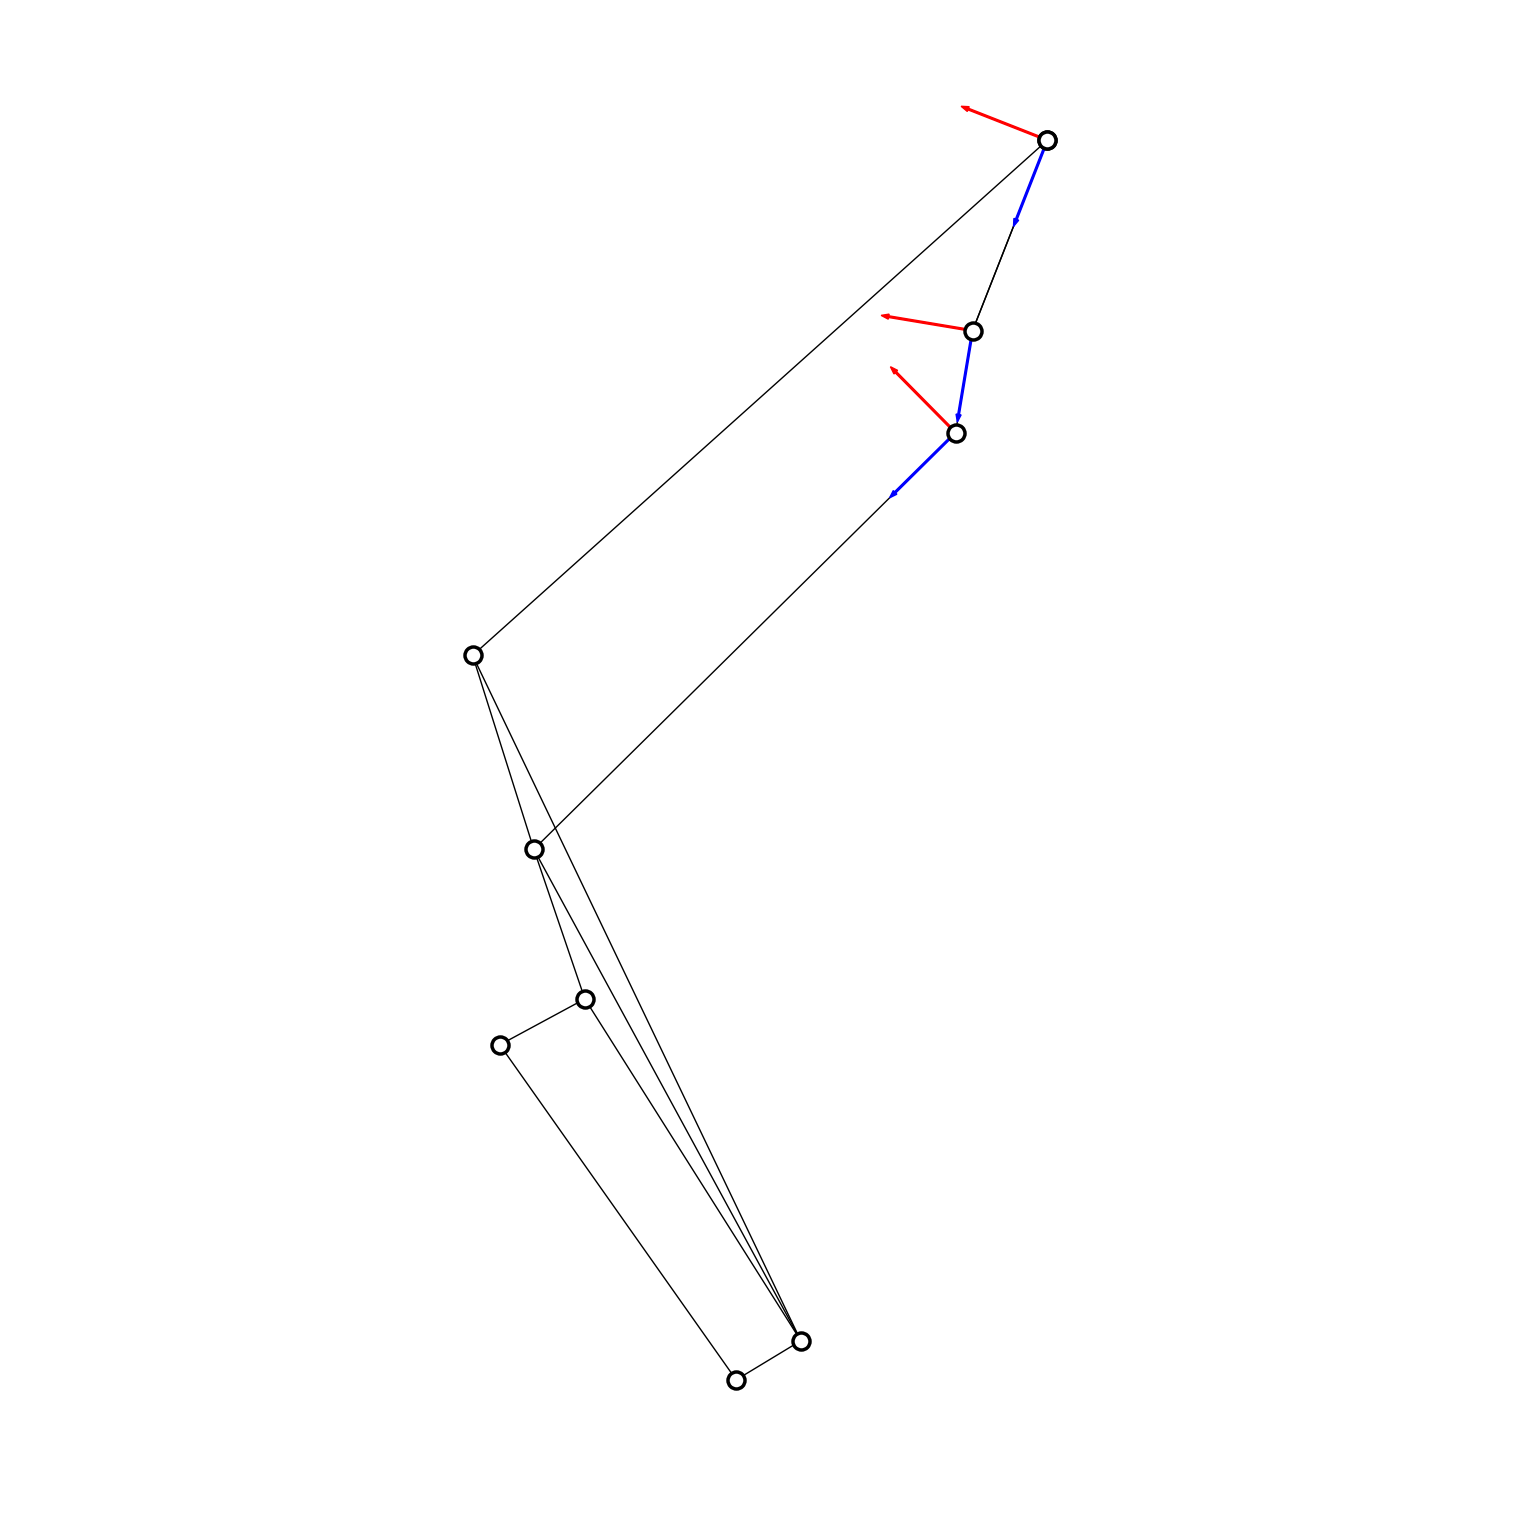

In [17]:
h_ex = np.array([ex[0],ex[1],ex[2],0])
h_ez = np.array([ez[0],ez[1],ez[2],0])

p0 = np.zeros(4)
p0[3] = 1


plt.figure(figsize=(15, 15))
nx.draw(graph, pos, node_color="w", linewidths=2.5, edgecolors="k", node_shape="o",node_size=150, with_labels=False)
v1x = H_w_b1 @ h_ex
e1z = H_w_b1 @ h_ez
p1 = H_w_b1 @ p0
plt.arrow(p1[0], p1[2],e1z[0]*0.05,e1z[2]*0.05, color="b")
plt.arrow(p1[0], p1[2],v1x[0]*0.05,v1x[2]*0.05, color="r")

e2z = H_w_b1 @ H_b1_b2 @ h_ez
v2x = H_w_b1 @ H_b1_b2 @ h_ex
p2 = H_w_b1 @ H_b1_b2 @ p0
plt.arrow(p2[0], p2[2],e2z[0]*0.05,e2z[2]*0.05, color="b")
plt.arrow(p2[0], p2[2],v2x[0]*0.05,v2x[2]*0.05, color="r")

e3z = H_w_b1 @ H_b1_b2 @ H_b2_b3 @ h_ez
v3x = H_w_b1 @ H_b1_b2 @ H_b2_b3 @ h_ex
p3 = H_w_b1 @ H_b1_b2 @ H_b2_b3 @ p0
plt.arrow(p3[0], p3[2],e3z[0]*0.05,e3z[2]*0.05, color="b")
plt.arrow(p3[0], p3[2],v3x[0]*0.05,v3x[2]*0.05, color="r")

plt.axis("equal")

(-0.37349000000000004, 0.03549000000000001, -0.805545, 0.076545)

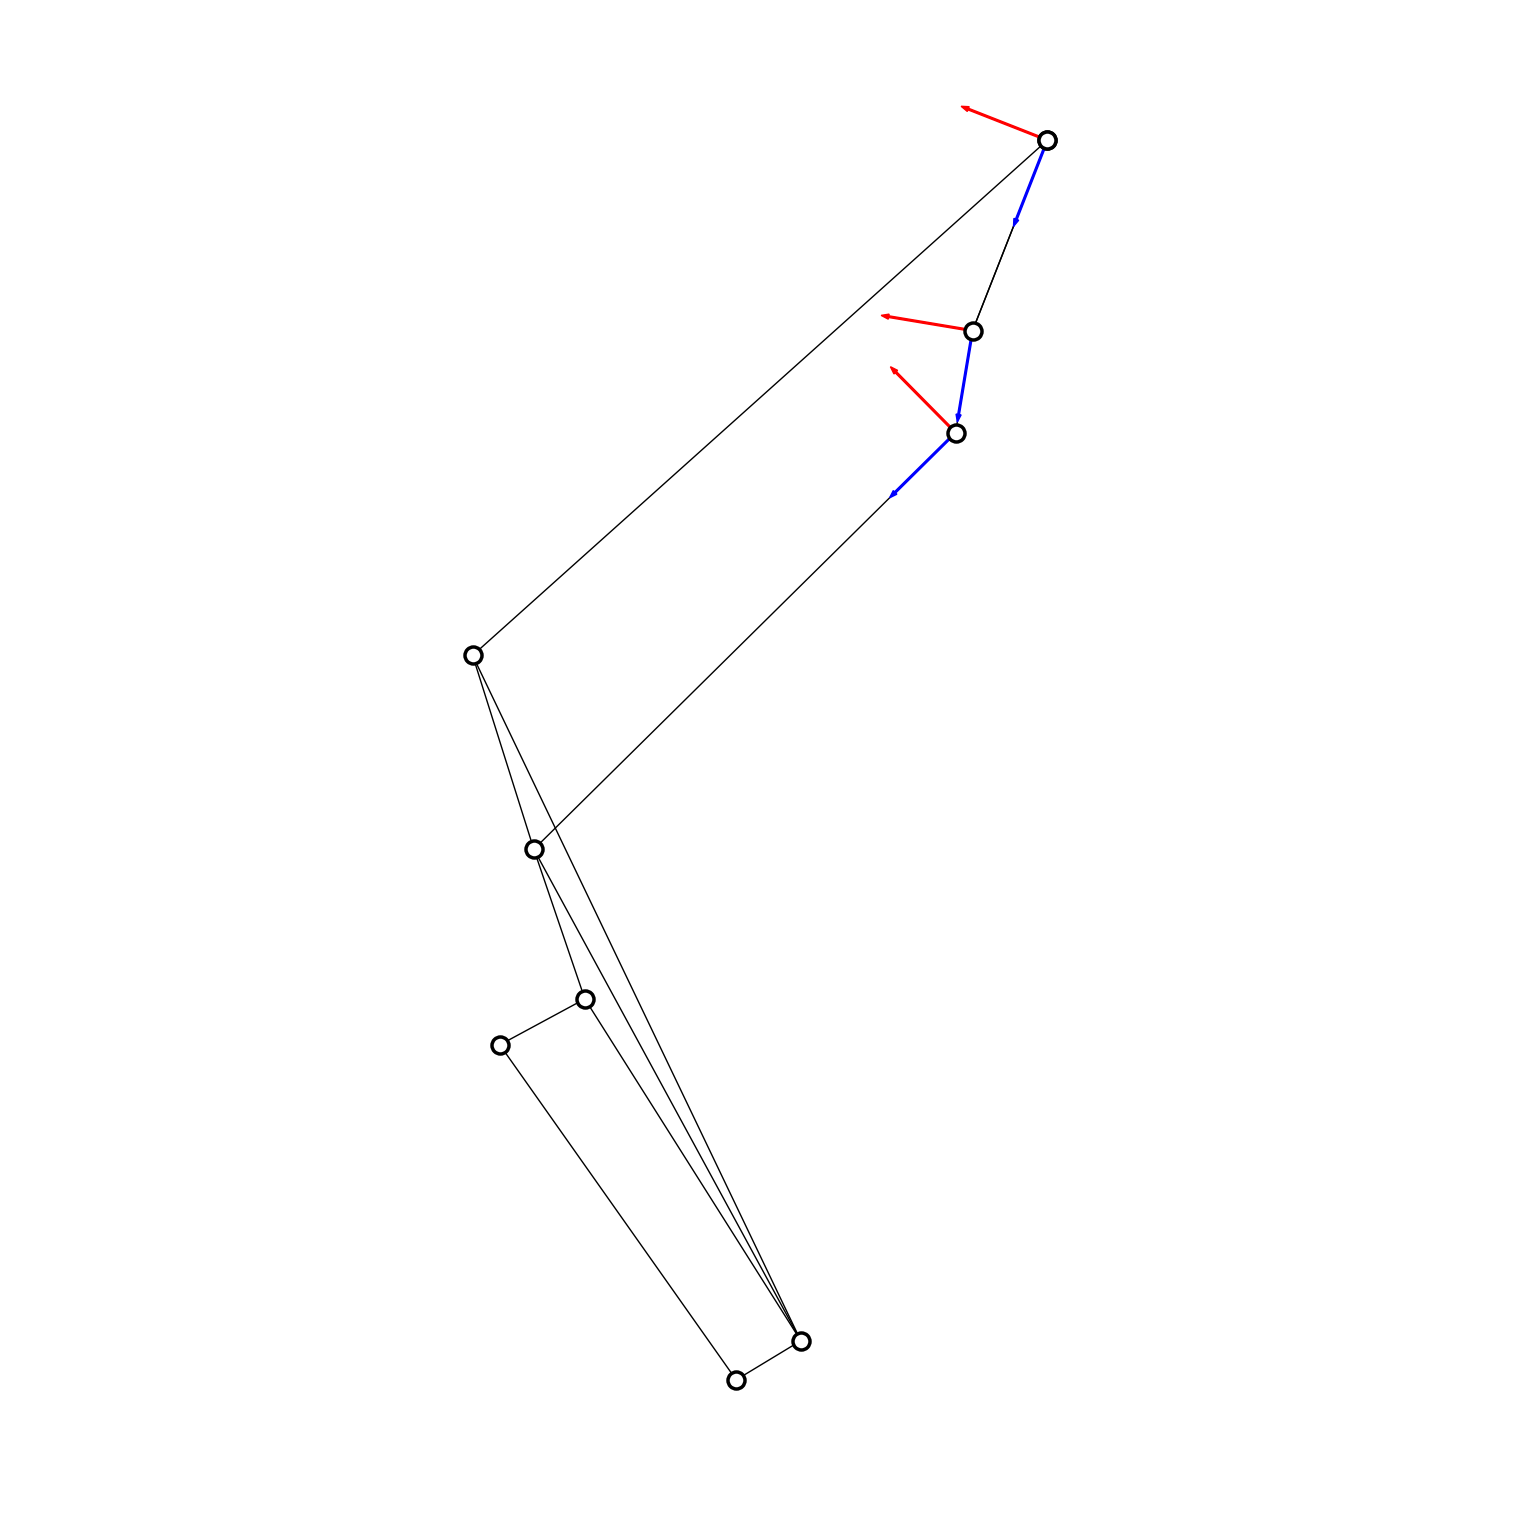

In [19]:


q1 = 0
q2 = 0
q3 = 0
plt.figure(figsize=(15, 15))
nx.draw(graph, pos, node_color="w", linewidths=2.5, edgecolors="k", node_shape="o",node_size=150, with_labels=False)
v1x = R1(q1).as_matrix() @ ex
e1z = R1(q1).as_matrix() @ ez
plt.arrow(main_branch[0].r[0],main_branch[0].r[2],e1z[0]*0.05,e1z[2]*0.05, color="b")
plt.arrow(main_branch[0].r[0],main_branch[0].r[2],v1x[0]*0.05,v1x[2]*0.05, color="r")

e2z = R1(q1).as_matrix() @ R2(q2).as_matrix() @ ez
v2x = R1(q1).as_matrix() @ R2(q2).as_matrix() @ ex
plt.arrow(main_branch[1].r[0],main_branch[1].r[2],e2z[0]*0.05,e2z[2]*0.05, color="b")
plt.arrow(main_branch[1].r[0],main_branch[1].r[2],v2x[0]*0.05,v2x[2]*0.05, color="r")

e3z = R1(q1).as_matrix() @ R2(q2).as_matrix() @ R3(q3).as_matrix() @ ez
v3x = R1(q1).as_matrix() @ R2(q2).as_matrix() @ R3(q3).as_matrix() @ ex
plt.arrow(main_branch[2].r[0],main_branch[2].r[2],e3z[0]*0.05,e3z[2]*0.05, color="b")
plt.arrow(main_branch[2].r[0],main_branch[2].r[2],v3x[0]*0.05,v3x[2]*0.05, color="r")

plt.axis("equal")

In [35]:
testR = R2(0.209).as_matrix()

test_th = np.arccos((np.trace(testR) - 1)/2)

test_omg = 1 / 2 / np.sin(test_th) * np.array([[testR[2,1]-testR[2,1]], [testR[0,2]-testR[2,0]], [testR[1,0]-testR[0,1]]])

np.pi/4, test_th, test_omg

(0.7853981633974483,
 0.0001849385921899674,
 array([[ 0.],
        [-1.],
        [ 0.]]))

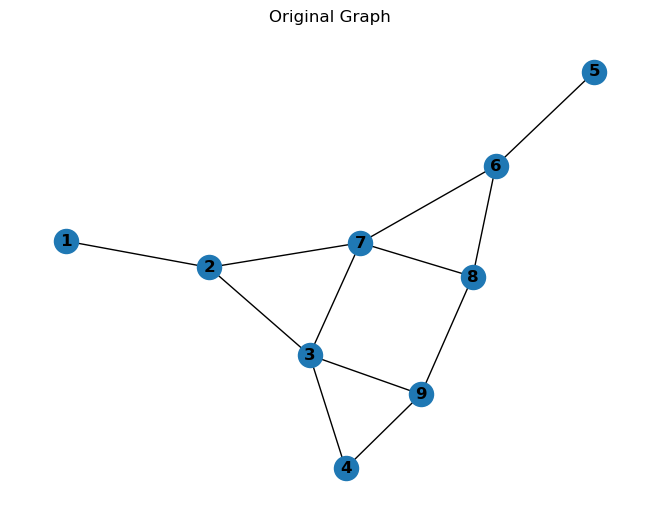

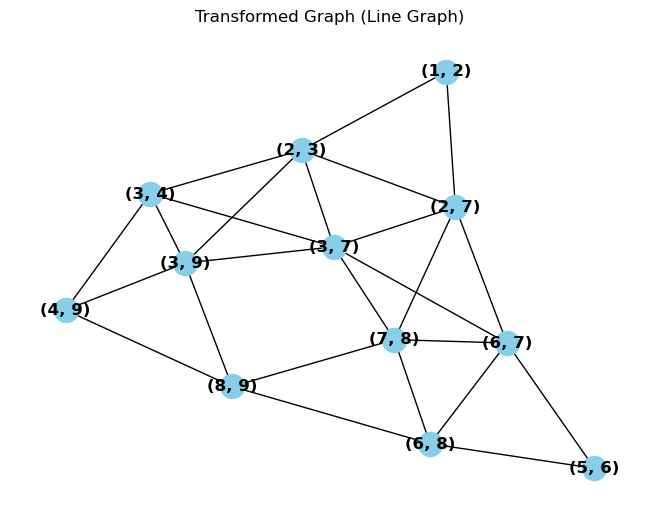

In [20]:
G = nx.Graph()#cassie_graph
# G.add_edges_from([(1, 2), (2, 3), (3, 1), (3, 4)])
G.add_edges_from([(1, 2), (2,3), (3, 4), (5,6), (6,7), (7,2), (7,3)])
G.add_edges_from([(6,8),(7,8),(8,9),(9,3),(9,4)])

# Visualize the original graph
nx.draw(G, with_labels=True, font_weight='bold')
plt.title('Original Graph')
plt.show()

# Convert nodes to edges and edges to nodes (Line Graph Transformation)
line_graph = nx.line_graph(G)

# Visualize the transformed graph
nx.draw(line_graph, with_labels=True, font_weight='bold', node_color='skyblue')
plt.title('Transformed Graph (Line Graph)')
plt.show()

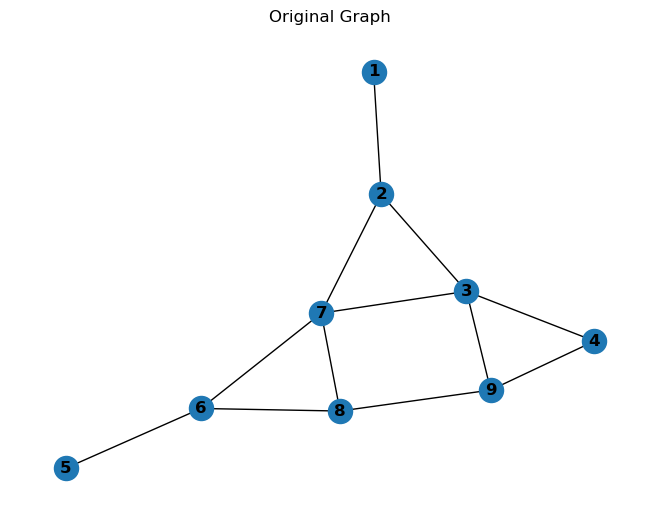

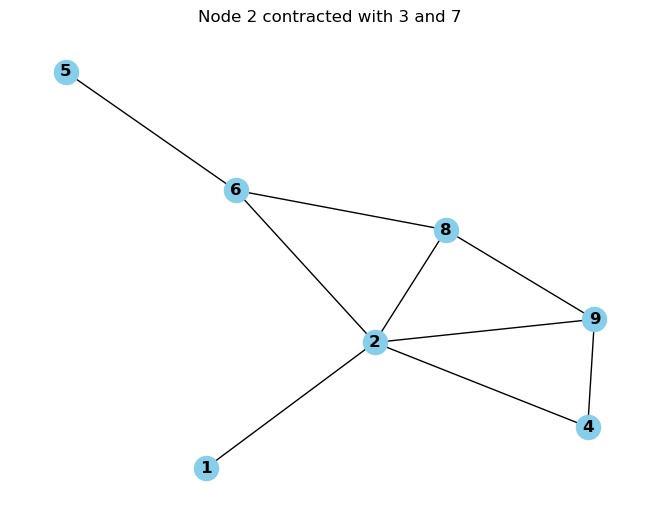

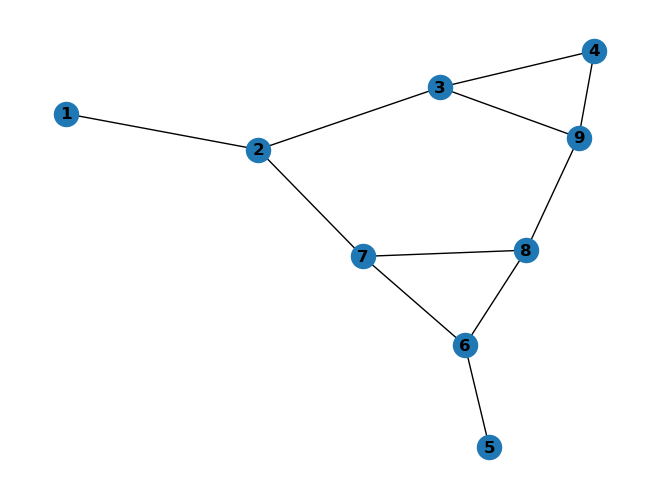

NetworkXError: nbunch is not a node or a sequence of nodes.

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

def custom_line_graph_transformation(graph):
    out_graph = nx.Graph()
    line_graph = graph.copy()
    counter = 0
    for node in graph.nodes():
        if node not in line_graph.nodes():
            continue
        neighbors = list(graph.neighbors(node))
        
        for i in range(len(neighbors)):
            for j in range(i + 1, len(neighbors)):
                if graph.has_edge(neighbors[i], neighbors[j]):
                    nx.contracted_nodes(line_graph, node, neighbors[i], self_loops=False, copy=False)
                    nx.contracted_nodes(line_graph, node, neighbors[j], self_loops=False, copy=False)
                    out_graph.add_node(f"L{counter}_3", g=False, joints=[node, neighbors[i], neighbors[j]])
                    # line_graph.remove_node(node)
                    nx.draw(line_graph, with_labels=True, font_weight='bold', node_color='skyblue')
                    plt.title(f"Node {node} contracted with {neighbors[i]} and {neighbors[j]}")
                    plt.show()
                    # graph.remove_edge(node, neighbors[i])
                    # graph.remove_edge(node, neighbors[j])
                    graph.remove_edge(neighbors[i], neighbors[j])
                    nx.draw(graph, with_labels=True, font_weight='bold')
                    plt.show()
    out_graph.add_node("G", joints=[])
    for node in graph.nodes():
        if graph.nodes[node].get("g"):
            out_graph.nodes["G"]["joints"].append(node)
    for edge in graph.edges():
        out_graph.add_node(f"L{counter}", g=False, joints=[edge[0], edge[1]])
        counter += 1
    for node1 in out_graph.nodes():
        joints = out_graph.nodes[node1]["joints"]
        for j in joints:
            if graph.nodes[j].get("g"):
                out_graph.add_edge(node1, "G", weight=j)
        for node2 in out_graph.nodes():
            if node1 == node2 and not (node1 != "G" and node2 != "G"):
                continue
            # print(out_graph.nodes[node1], out_graph.nodes[node2])
            intersection = set(out_graph.nodes[node1]["joints"]) & set(out_graph.nodes[node2]["joints"])
            # print(f"node1: {node1}, node2: {node2}, intersection: {intersection}")
            if len(intersection) == 1:
                out_graph.add_edge(node1, node2, weight=intersection.pop())
        if node == "G":
            continue
    return out_graph

# Create an example graph
G1 = G.copy()
G1.nodes[1]["g"] = True
G1.nodes[5]["g"] = True
# G.add_edges_from([(1, 2), (2, 3), (3, 1), (3, 4)])

# Visualize the original graph
nx.draw(G1, with_labels=True, font_weight='bold')
plt.title('Original Graph')
plt.show()

# Perform Custom Line Graph Transformation
newG = custom_line_graph_transformation(G1)

# Visualize the transformed graph
pos = nx.spring_layout(newG)
nx.draw_networkx_nodes(newG, pos)
nx.draw_networkx_edges(newG, pos)
nx.draw_networkx_labels(newG, pos)
nx.draw_networkx_edge_labels(
    newG,pos, edge_labels={(u, v): d["weight"] for u, v, d in newG.edges(data=True)})
plt.title('Transformed Graph (Custom Line Graph)')
plt.show()

In [93]:
newG.nodes["G"]

{'joints': [1, 5]}